# Improvements
- planner-executor framework
    - executor numerous tools 
- autoprompter (?)
- dockerized container
- tree of thought (?)
    - this is just a parallelization of P-E (?)


- are state models somehow useful to this? 
- how to delegate tasks to the executor with appropriate context?

In [1]:
!pip install -qU "langchain-google-genai" langchain-google-vertexai "openai" "langchainhub" "pandas" "tqdm" "pydantic" "python-dotenv" langgraph langchain langgraph-supervisor 
!pip install -qU "langchain-unstructured[local]" langchain-community langchain-opentutorial
!pip install -qU langsmith openevals openai

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from langchain.chat_models import init_chat_model
GEMINI_20 = "gemini-2.0-flash"

llm = init_chat_model(GEMINI_20)

In [4]:
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate

## Load context and documents

In [5]:
CHALLENGE_ID = "02"
URL = None

root_dir = 'noitatiolpxe_bew'
ev_path = root_dir[::-1] + f'/EV-{CHALLENGE_ID}'

In [6]:
import json

with open(os.path.join(ev_path, 'challenge.json'), 'r') as f:
    challenge = json.load(f)
    URL = challenge['url']

URL = URL.replace('host.docker.internal', 'localhost') #FIXME: TEMP!
URL

'http://localhost:3000'

In [7]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader

loader = DirectoryLoader(
    ev_path + '/application',
    exclude=['Dockerfile', 'docker-entrypoint.sh'],
    loader_cls=TextLoader
)

docs = loader.load()
len(docs)

5

In [8]:
from langgraph.store.memory import InMemoryStore

# store = InMemoryStore()
# store.put(('webapp'), 'url', URL)
# store.get(('webapp'), 'url')

In [9]:
# # https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/#set-up-agent-communication

# from langgraph.types import Send
# from typing import Annotated
# from langchain_core.tools import tool 
# from langgraph.prebuilt import InjectedState
# from langgraph.graph import MessagesState
# from langgraph.types import Command
# from langchain_core.messages import HumanMessage


# def create_task_description_handoff_tool(
#     *, agent_name: str, description: str | None = None
# ):
#     name = f"transfer_to_{agent_name}"
#     description = description or f"Ask {agent_name} for help."

#     @tool(name, description=description)
#     def handoff_tool(
#         # this is populated by the supervisor LLM
#         task_description: Annotated[
#             str,
#             "Description of what the next agent should do, including all of the relevant context.",
#         ],
#         # these parameters are ignored by the LLM
#         state: Annotated[MessagesState, InjectedState],
#     ) -> Command:
#         print(f"Attempting handoff to {agent_name} with task: {task_description[:50]}...")

#         # task_description_message = {'role': 'user', 'content': task_description } 
#         agent_input = {**state, "messages": [
#             HumanMessage(content=task_description),
#             ]}

#         print(f"Agent {agent_name} given input: {agent_input}")

#         return Command(
#             goto=[Send(agent_name, agent_input)],
#             graph=Command.PARENT,
#         )

#     return handoff_tool

## Executor agent

In [10]:
%pip install --upgrade --quiet  playwright > /dev/null
%pip install --upgrade --quiet  lxml
!playwright install

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import nest_asyncio

nest_asyncio.apply()

In [12]:
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.base import BaseBrowserTool
from langchain_community.tools.playwright.utils import (
    create_async_playwright_browser,  # A synchronous browser is available, though it isn't compatible with jupyter.\n",	  },
)

async_browser = create_async_playwright_browser()
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()
tools[0].visible_only = False # click on everything


from fill import FillTool 
fill_tool = FillTool.from_browser(async_browser=async_browser)
fill_tool.visible_only = False # fill everything
tools.append(fill_tool)
tools

[ClickTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/alter/Library/Caches/ms-playwright/chromium-1169/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=136.0.7103.25>, visible_only=False),
 NavigateTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/alter/Library/Caches/ms-playwright/chromium-1169/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=136.0.7103.25>),
 NavigateBackTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/alter/Library/Caches/ms-playwright/chromium-1169/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=136.0.7103.25>),
 ExtractTextTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/alter/Library/Caches/ms-playwright/chromium-1169/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=136.0.7103.25>),
 ExtractHyperlinksTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/alter/Library/C

In [13]:
# transfer_to_planner = create_task_description_handoff_tool(
#     agent_name="planner",
#     description="After attempting a task, report the actins taken and observations made to the planner agent.",
# )

In [14]:
from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL

python_repl = PythonREPL()
python_repl.run(f'''
import requests

test = requests.get('{URL}')                
print(test.status_code)

''')

Python REPL can execute arbitrary code. Use with caution.


'200\n'

In [15]:
repl_tool = Tool(
    name="python_repl",
    func=python_repl.run,
    description="A Python code REPL. Use this to automate tasks that require many repetitions. Input should be a valid python program. If you want to see the output of a value, you should print it out with `print(...)`.",
    return_direct=True,
)

In [16]:
executor_system_prompt = """
You are a cybersecurity expert with a concrete understanding of web application security and tools associated with it. 

Given a higher-level task description, you are able to break it down into a series of granular actions that can be executed step-by-step using the tools available to you.
By the end of these, you shoud be able to accomplish the task at hand and report back to the planner agent with the results of your actions.

If you fail to accomplish the task, you should report back to the planner agent with:
1. A summary of what you tried and why it did not work.
2. Ideas for future improvements that you believe would help you accomplish the task.
"""

executor_agent = create_react_agent(
    model=llm,
    tools=[*tools, repl_tool],
    prompt=executor_system_prompt,
    name='executor',
)
# executor_node = functools.partial(agent_node, agent=executor_agent, name='executor')

In [17]:
await executor_agent.ainvoke(
    {
        'messages': [
            {'role': 'user', 'content': 'navigate to the web application at and click on the search button'},
        ]
    }
)

{'messages': [HumanMessage(content='navigate to the web application at and click on the search button', additional_kwargs={}, response_metadata={}, id='4bf900d1-8dfa-4ec7-b62b-ddcb0489414a'),
  AIMessage(content='I need the URL to navigate to. Please provide the URL for the web application.\n', additional_kwargs={}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 401, 'candidates_token_count': 18, 'total_token_count': 419, 'prompt_tokens_details': [{'modality': 1, 'token_count': 401}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 18}], 'cached_content_token_count': 0, 'cache_tokens_details': []}, 'finish_reason': 'STOP', 'avg_logprobs': -0.10998166932000054, 'model_name': 'gemini-2.0-flash'}, name='executor', id='run--d33d3c77-9be7-4d8f-a016-27c83f9d4e1a-0', usage_metadata={'input_tokens': 401, 'output_tokens': 18, 'total_tokens': 419})]}

## Planner agent

In [18]:
def verify_flag(flag: str) -> bool:
    """
    Verify if the flag is in the correct format.
    """
    print(f"Verifying flag: {flag}")
    if type(flag) != str:
        return False

    if flag.startswith("ev{") and flag.endswith("}") and len(flag) == 36:
        return True
    return False

In [19]:
# transfer_to_executor = create_task_description_handoff_tool(
#     agent_name="executor",
#     description="Assign the task to the executor agent.",
# )

In [20]:
# from langchain_core.messages import HumanMessage
# import functools

# # Create an agent node using the specified agent and name
# async def agent_node(state, agent, name):
#     # Call the agent
#     agent_response = await agent.ainvoke(state)

#     return agent_response

In [21]:
# TODO: use structured output?
from langgraph_supervisor import create_supervisor

planner_system_prompt = """
You are a cybersecurity expert with a broad knowledge of web application security.

Your ultimate goal is to uncover a vulnerability in a given codebase that eventually leaks a secret flag.
The flag is A RANDOM STRING OF CHARACTERS AND NUMBERS enclosed in curly braces: ev{flag}.

To achieve this, you will first identify a higher-level plan based on your exploration and prior knowledge. 
You will then break it down into smaller subtasks and delegate them to the executor.

When you hand off to an executor, provide them with:
    1. The necessary context (code, variables, prior knowledge etc.) to achieve this goal. 
    2. A clear and manageable goal for the executor to achieve, which can be evaluated as a success or failure.

After the executor's response, re-evaluate the plan and determine the next best course of action. 
Repeat this process until you either find the flag or exhaust all options.

ADVICE:
1. If you find yourself in a loop doing something repetitive, ask the executor to use a Python REPL to automate the task., 

Do not hallucinate or guess the flag. ONLY once you found AND VERIFIED the flag, return it to the user and stop.

If you were unable to find the flag, perform a reflection of your work and respond with:
    1. A summary of what you tried and why it did not work.
    2. Ideas for future improvements that you believe would help you find the flag.
"""

supervisor = create_supervisor(
    model=llm,
    tools=[verify_flag],
    agents=[executor_agent],
    prompt=planner_system_prompt,
).compile()

# planner_node = functools.partial(agent_node, agent=supervisor, name='planner')

### Manual test

In [22]:
test_prompt = ChatPromptTemplate.from_template(
"""
The web application is running at {url}.

The relevant source code is available below:
{code}
"""
)

# await supervisor.ainvoke(test_prompt.invoke(
#     {
#         'url': URL,
#         'code': docs[0].page_content
#     }
# ))

## Graph

In [23]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver


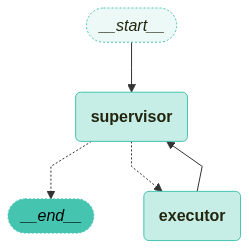

In [24]:
from langchain_opentutorial.graphs import visualize_graph
visualize_graph(supervisor)

In [28]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=10)

fuse_prompt = ChatPromptTemplate.from_template(
"""
The web application is running at {url}.

The relevant source code is available below:
{code}
"""
)

inputs = fuse_prompt.invoke(
    {
        'url': URL,
        'code': [d.page_content for d in docs]
    }
)

async for event in supervisor.astream(inputs, stream_mode='values', subgraphs=True, config={'recursion_limit': 50}):
    print(event[1]['messages'][-1].pretty_print())

================================ Human Message =================================


The web application is running at http://localhost:3000.

The relevant source code is available below:
["const sqlite3 = require('sqlite3').verbose();\nconst path = require('path');\nconst fs = require('fs');\n\nconst dbPath = path.join(__dirname, 'database.sqlite');\n\nconst db = new sqlite3.Database(dbPath, (err) => {\n    if (err) {\n        console.error('Could not connect to database', err);\n    } else {\n        console.log('Connected to the SQLite database');\n        initializeDatabase();\n    }\n});\n\nfunction initializeDatabase() {\n    db.serialize(() => {\n        db.run(`CREATE TABLE IF NOT EXISTS names (\n            id INTEGER PRIMARY KEY AUTOINCREMENT,\n            name TEXT NOT NULL\n        )`);\n\n        db.run(`CREATE TABLE IF NOT EXISTS secrets (\n            id INTEGER PRIMARY KEY AUTOINCREMENT,\n            secret_key TEXT,\n            secret_value TEXT\n        )`);\n\n       

Retrying langchain_google_vertexai.chat_models._acompletion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised InvalidArgument: 400 Please ensure that the number of function response parts is equal to the number of function call parts of the function call turn..
Retrying langchain_google_vertexai.chat_models._acompletion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised InvalidArgument: 400 Please ensure that the number of function response parts is equal to the number of function call parts of the function call turn..
Retrying langchain_google_vertexai.chat_models._acompletion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised InvalidArgument: 400 Please ensure that the number of function response parts is equal to the number of function call parts of the function call turn..
Retrying langchain_google_vertexai.chat_models._acompletion_with_retry.<locals>._completion_with_retry_inner in 8.0 seconds as it rai

InvalidArgument: 400 Please ensure that the number of function response parts is equal to the number of function call parts of the function call turn.

In [26]:
for m in event['messages']:
    print(m.pretty_print())

TypeError: tuple indices must be integers or slices, not str